# Regression model

In [19]:
from IPython.display import Image, display, clear_output
import os
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch


from torch import nn
from torch.utils.data import random_split, DataLoader
from scipy.stats import gaussian_kde

## Loading data

### Loading from files

In [20]:
# Paths for the dimensionally reduced gene expression datasets used in the analysis.
train_data_path = os.getcwd() + "/Data/gtex_gene_expression_encoded.npy"
#train_data_path = os.getcwd() + "/Data/gtex_gene_pca_4.npy"

# Path for loading the data subset of 965 isoforms which we used for our regression analysis
labels_data_path = os.getcwd()+"/Data/gtex_isoform_expression_965_subset.npy"

# # Path for the full dataset with 197000 isoforms. We did not use this for our analysis.
# labels_data_path = os.getcwd()+"/Data/gtex_isoform_expression_log2_transposed.npy" # FULL 200k isoforms

inputs = np.load(train_data_path)
assert np.isnan(np.sum(inputs)) == False

y = np.load(labels_data_path)
assert np.isnan(np.sum(y)) == False

#### Subsetting the isoform expression dataset

In [21]:
# Remove columns that only contain 0s (unexpressed isoforms)
zero_idx = np.argwhere(np.all(y[..., :] == 0, axis=0))
print(f"Number of columns that only contain zeros: {zero_idx.shape[0]}")
y = np.delete(y, zero_idx, axis=1)

Number of columns that only contain zeros: 0


(array([2.01927e+05, 1.04238e+05, 7.13330e+04, 5.19160e+04, 3.85430e+04,
        3.07990e+04, 2.56220e+04, 2.31370e+04, 1.99470e+04, 1.86010e+04,
        1.79560e+04, 1.72460e+04, 1.43900e+04, 1.45840e+04, 1.32020e+04,
        8.55400e+03, 3.52200e+03, 1.50600e+03, 2.68000e+02, 3.10000e+01]),
 array([1.43552795e-02, 7.32059479e-01, 1.44976366e+00, 2.16746783e+00,
        2.88517189e+00, 3.60287619e+00, 4.32058048e+00, 5.03828430e+00,
        5.75598860e+00, 6.47369289e+00, 7.19139719e+00, 7.90910101e+00,
        8.62680531e+00, 9.34450912e+00, 1.00622139e+01, 1.07799177e+01,
        1.14976225e+01, 1.22153263e+01, 1.29330301e+01, 1.36507349e+01,
        1.43684387e+01], dtype=float32),
 <BarContainer object of 20 artists>)

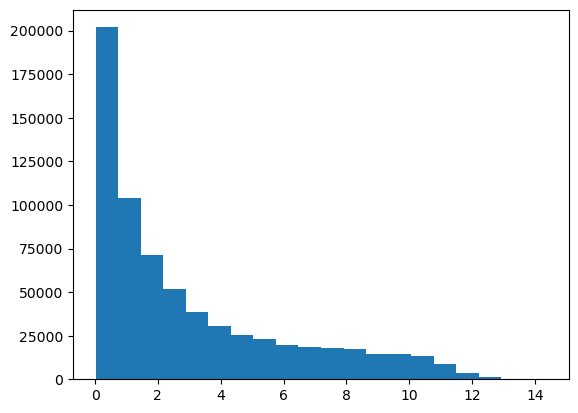

In [22]:
# Distribution of non-zero values
plt.hist(y[y > 0], bins=20)

In [23]:
# 17382 input samples containign 64 independent variables which are used to predict 965 dependent variables
inputs = torch.from_numpy(inputs)
y = torch.from_numpy(y)

In [24]:
inputs.shape

torch.Size([1000, 4])

In [25]:
y.shape

torch.Size([1000, 965])

#### Data annotations

In [26]:
GTEX_FOR_LABELS = os.getcwd()+"/Data/iso_02456/gtex_gene_expression_subset.tsv"
GTEX_TISSUE_ANNOTATIONS_PATH = os.getcwd()+"/Data/iso_02456/gtex_annot.tsv"

file = open(GTEX_FOR_LABELS)

colnames = file.readline().split("\t")
colnames = [i.replace('\n','') for i in colnames]

file.close()

In [27]:
tissues_dict = {}
with open(GTEX_TISSUE_ANNOTATIONS_PATH) as f:
    for line in f:
        (key,val) = line.split("\t")
        tissues_dict[key] = val
        
tissue = []
for sample in colnames:
    tissue.append(tissues_dict[sample])
tissue = [i.replace('\n','') for i in tissue]

In [28]:
for i in range(len(tissue)):
    if 'Adipose' in tissue[i]:
        tissue[i] = 'Adipose'
    elif 'Artery' in tissue[i]:
        tissue[i] = 'Artery'
    elif 'Brain' in tissue[i]:
        tissue[i] = 'Brain'
    elif 'Cervix' in tissue[i]:
        tissue[i] = 'Cervix'
    elif 'Colon' in tissue[i]:
        tissue[i] = 'Colon'
    elif 'Heart' in tissue[i]:
        tissue[i] = 'Heart'
    elif 'Esophagus' in tissue[i]:
        tissue[i] = 'Esophagus'
    elif 'Kidney' in tissue[i]:
        tissue[i] = 'Kidney'
    elif 'Skin' in tissue[i]:
        tissue[i] = 'Skin'

In [29]:
set(tissue)

{'Adipose',
 'Adrenal Gland',
 'Artery',
 'Bladder',
 'Brain',
 'Breast - Mammary Tissue',
 'Cells - Cultured fibroblasts',
 'Cells - EBV-transformed lymphocytes',
 'Cervix',
 'Colon',
 'Esophagus',
 'Heart',
 'Kidney',
 'Liver',
 'Lung',
 'Minor Salivary Gland',
 'Muscle - Skeletal',
 'Nerve - Tibial',
 'Ovary',
 'Pancreas',
 'Pituitary',
 'Prostate',
 'Skin',
 'Small Intestine - Terminal Ileum',
 'Spleen',
 'Stomach',
 'Testis',
 'Thyroid',
 'Uterus',
 'Vagina',
 'Whole Blood'}

#### Turning data into a torch dataset

In [30]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, x_data, y_data):
        self.x_data = x_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]


    def __len__(self):
        return len(self.x_data)

dataset = CustomDataset(inputs, y)

#### Setting up torch dataloader

In [31]:
### Creating the DataLoader
batch_size=64
num_workers=4
shuffle=True
pin_memory=True

# # Randomly splitting data
# data_train, data_test = random_split(dataset, [0.8, 0.2])

# Select tissues to hold out for testing - selection based on UMAP from 
idx = [i for i in range(len(tissue)) if tissue[i] == 'Brain' or tissue[i] == 'Pituitary']

data_train = [dataset[i] for i in range(len(dataset)) if i not in idx]
data_test = [dataset[i] for i in idx]



# Training data:
train_loader = DataLoader(dataset = data_train,
                            batch_size = batch_size,
                            shuffle = True,
                            num_workers=num_workers, 
                            pin_memory=pin_memory)
print(f"Number of training samples: {len(train_loader.dataset)}")

# Testing data:
test_loader = DataLoader(dataset = data_test,
                            batch_size = batch_size,
                            shuffle = True,
                            num_workers=num_workers, 
                            pin_memory=pin_memory)
print(f"Number of test samples: {len(test_loader.dataset)}")

Number of training samples: 840
Number of test samples: 160


In [32]:
# Checking the data that will be the input as batch : 64 samples and 64 latent variables
data_train = next(iter(train_loader))
print(data_train[0].shape) # Shape of input X
print(data_train[1].shape) # Shape of the Y we need to obtain

torch.Size([64, 4])
torch.Size([64, 965])


## Setting up model

In [33]:
class FFNet(nn.Module):
    def __init__(self, input_shape:torch.Size, output_features:int, hidden_layer_sizes:list) -> None:
        super(FFNet, self).__init__()
    
        self.input_shape = input_shape
        self.observation_features = np.prod(input_shape)
        
        self.output_features = output_features
        
        self.hidden_layer_sizes = hidden_layer_sizes
        self.n_hidden_layers = len(hidden_layer_sizes)
        
        # Network layers
        layers = [nn.Linear(self.observation_features, self.hidden_layer_sizes[0]), nn.BatchNorm1d(self.hidden_layer_sizes[0]), nn.ReLU()]
        for i in range(self.n_hidden_layers-1):
            layers.append(nn.Linear(self.hidden_layer_sizes[i], self.hidden_layer_sizes[i+1]))
            layers.append(nn.BatchNorm1d(self.hidden_layer_sizes[i+1]))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(self.hidden_layer_sizes[-1], self.output_features))
        layers.append(nn.ReLU())
        
        self.network = nn.Sequential(*layers)
        
    def forward(self, x):
        out = self.network(x)
        return out

In [34]:
input_shape = data_train[0].shape[1] # shape of each sample in the input batch
output_features = y.shape[1] # Here we need the number of protein splice isoforms we are trying to regress
hidden_layer_sizes = [128, 256] # Specify the network

net = FFNet(input_shape, output_features, hidden_layer_sizes)
print(net)

FFNet(
  (network): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=256, bias=True)
    (4): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU()
    (6): Linear(in_features=256, out_features=965, bias=True)
    (7): ReLU()
  )
)


In [35]:
# Defining the loss function
criterion = nn.MSELoss()

# Defining the optimizer, learning rate and weight decay
optimizer = torch.optim.Adam(net.parameters(), lr=1e-4, weight_decay=1e-4)

## Train

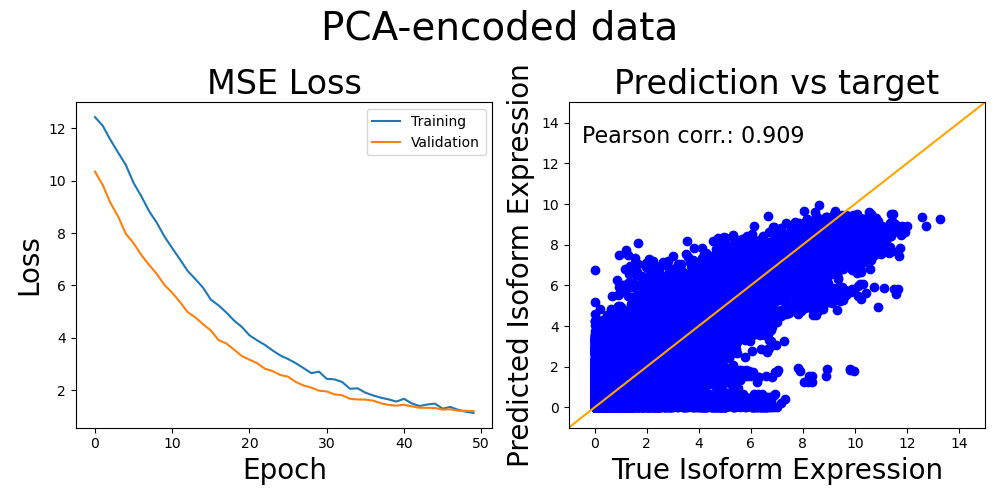

In [36]:
num_epochs = 50
epoch = 0

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f">> Using device: {device}")

net.to(device)

# define dictionary to store the training curves
training_data = defaultdict(list)
validation_data = defaultdict(list)

# For plotting
tmp_img="tmp_vae_out.png"

print(f"Training for {num_epochs} epochs starting!")
while epoch < num_epochs:
    epoch+= 1
    
    train_epoch_data = defaultdict(list)
    test_epoch_data = defaultdict(list)
    
    net.train()
    for x, y in train_loader:
        x = x.to(device)
        y = y.to(device)
        
        #clear the gradients
        optimizer.zero_grad()    

        # Make a prediction using the model  
        y_pred_train = net(x)
        
        # Compute the loss using the predicted and actual y values
        train_loss = criterion(y_pred_train, y)

        # Backpropagate the gradients
        train_loss.backward()

        # Update the model weights
        optimizer.step()
        
        # Appends data to dict of train loss
        train_epoch_data['loss'] += [train_loss.detach().cpu().item()]
        
    # Takes mean of train loss across epoch
    training_data['loss'] += [np.mean(train_epoch_data['loss'])]
        
    with torch.no_grad():
        net.eval()
        
        for x, y in test_loader:
            x = x.to(device)
            y = y.to(device)
            
            y_pred_test = net(x)
            
            test_loss = criterion(y_pred_test, y)
            
            test_epoch_data['loss'] += [test_loss.detach().cpu().item()]
            
        # Takes mean of train loss across epoch
        validation_data['loss'] += [np.mean(test_epoch_data['loss'])]
    
    # For plotting the last test batch every epoch
    y = y.detach().cpu().numpy()
    y_pred_test = y_pred_test.detach().cpu().numpy()
    
    # Calculate pearson correlation coefficient
    corr_coef = round(np.corrcoef(y.flatten(), y_pred_test.flatten())[0,1], 3)
    
    # ##### Uncomment to calculate the point density - SLOW
    # xy = np.vstack([y.flatten(),y_pred_test.flatten()])
    # z = gaussian_kde(xy)(xy)
    # idx = z.argsort()
    # x, y, z = y.flatten()[idx], y_pred_test.flatten()[idx], z[idx]
    
    # ----------------------------------------------------------------------
    #### Plotting section
    fig,(ax1,ax2)=plt.subplots(nrows=1, ncols=2, figsize=(10,5))
    
    fig.suptitle("PCA-encoded data", fontsize=28)
    
    # Train and test loss
    ax1.plot(training_data['loss'], label="Training")
    ax1.plot(validation_data['loss'], label="Validation")
    ax1.set_title("MSE Loss", fontsize=24)
    ax1.set_xlabel("Epoch", fontsize=20)
    ax1.set_ylabel("Loss", fontsize=20)
    ax1.legend()
    
    # For plotting the last test batch every epoch
    ax2.plot(np.arange(-2,16), np.arange(-2,16), c='orange')
    
    ax2.scatter(y, y_pred_test, c="blue")
    # ###  Uncomment when plotting density and comment out above
    # ax2.scatter(x, y, c=z)
    
    ax2.text(x=-0.5,y=13, s=f"Pearson corr.: {corr_coef}", fontsize = 16)
    ax2.set_xlim(-1, 15)
    ax2.set_ylim(-1, 15)
    ax2.set_title("Prediction vs target", fontsize=24)
    ax2.set_xlabel("True Isoform Expression", fontsize=20)
    ax2.set_ylabel("Predicted Isoform Expression", fontsize=20)
    
    plt.tight_layout()
    plt.savefig(tmp_img)
    plt.close(fig)
    display(Image(filename=tmp_img))
    clear_output(wait=True)
    
    #if epoch > num_epochs:
    os.remove(tmp_img)
